# Культурист-Датасаентист

### Описание проекта

На основании имежщихся данных:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- поделить клиентов на 5 кластеров;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:


In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 80em; }</style>"))
import warnings
warnings.filterwarnings('ignore')

### Загрузка и знакомство с данными

In [2]:
client_data = pd.read_csv('путь к файлу')

In [3]:
client_data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<div class="alert alert-block alert-info">
    
- _gender_ — пол
    
- _Near_Location_ — проживание или работа в районе, где находится фитнес-центр
    
- _Partner_ — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
    
- _Promo_friends_ — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
    
- Phone_ — наличие контактного телефона
    
- _Contract_period_ — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
    
- _Group_visits_ — факт посещения групповых занятий
    
- _Age_ — возраст
    
- _Avg_additional_charges_total_ — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон
    
- _Month_to_end_contrac_ — срок до окончания текущего действующего абонемента (в месяцах)
    
- _Lifetime_ — время с момента первого обращения в фитнес-центр (в месяцах)
    
- Avg_class_frequency_total_ — средняя частота посещений в неделю за все время с начала действия абонемента
    
- _Avg_class_frequency_current_month_ — средняя частота посещений в неделю за предыдущий месяц
    
- _Churn_ - факт оттока в текущем месяце
    
</div>

### EDA

1) Проверить датасет на предмет пропусков, изучить средние значения и стандартные отклонения;

2) Посмотреть на средние значения признаков в двух группах — тех, кто ушел и тех, кто остался;
    
3) Построить столбчатые гистограммы распределения признаков для тех, кто ушёл и тех, кто остался;
    
4) Постройте матрицу корреляций и отобразите её.

In [4]:
# Переименуем слишком длинные имена столбцов и приведем их к нижнему регистру
client_data.columns = client_data.columns.str.lower()

In [5]:
# Посмотрим инфомацию о датасете
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

<div class="alert alert-block alert-info">
Пропусков в датасете нет, с типами данных тоже все в порядке, только количество месяцев до конца контракта нужно привести к целочисленному типу данных
</div>

In [6]:
client_data['month_to_end_contract'] = client_data['month_to_end_contract'].astype('int')

In [7]:
# Посмотрим на разброс значений наших данных
client_data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


<div class="alert alert-block alert-info">
На первый вгляд с данными все ОК, вернемся к анализу  распределения при построении гистограмм. Радует, что часть ушедших клиентов значительно нижу оставшихся. Также бросается в глаза, что нет ни одного клиента старше 41-го года, у нас фитнес-клуб для молодежи)
</div>

In [8]:
client_data.groupby(['churn']).mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


<div class="alert alert-block alert-info">
    
Отличительные черты клиентов, бросающих занятия:

- Меньшая длительность абонимента;

- Меньшая посещаемость групповых занятий;

- Меньший период до конца действия абонемента;

- Меньшее общее время занятий;

- Меньшая частота посещений тренировок

За исключением гендерной принадлежности и номера телефона, по остальным признакам отличие также в большую степень у остающихся клиентов, но уже не такое явное.
    </div>

In [9]:
# Разделим датасет
client_data_churn = client_data[client_data['churn'] == 1].drop('churn', axis=1)
client_data_no_churn = client_data[client_data['churn'] == 0].drop('churn', axis=1)

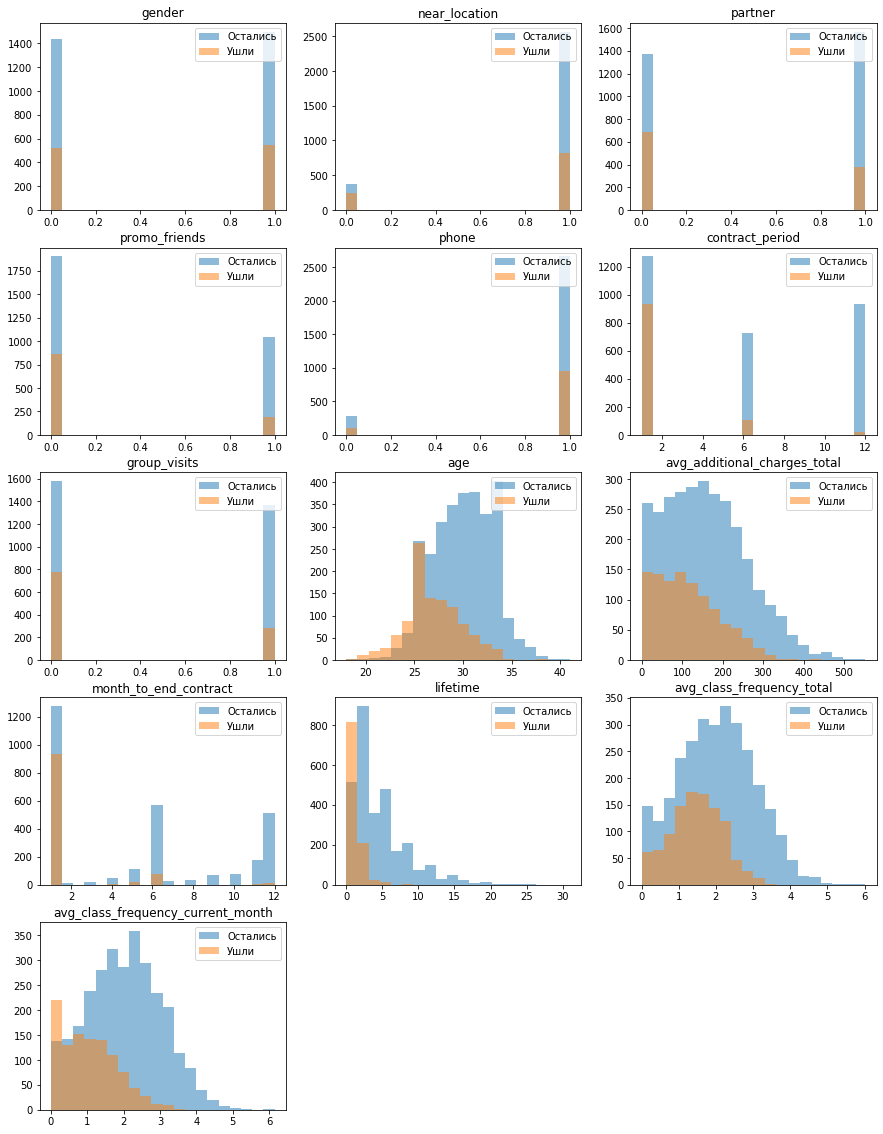

In [10]:
# построим гистограммы распределений
fig,ax = plt.subplots(5,3, figsize = (15,20))
ax = ax.ravel()
ax[-1].set_visible(False)
ax[-2].set_visible(False)
for i in range(len(client_data_churn.columns)):
    col_name = client_data_churn.columns[i]
    range_hist = (client_data[col_name].min(), client_data[col_name].max())
    ax[i].hist(client_data_no_churn[col_name], bins=20, range=range_hist, alpha = 0.5, label='Остались')
    ax[i].hist(client_data_churn[col_name], bins=20, range=range_hist, alpha = 0.5, label='Ушли')
    ax[i].legend(loc = 'upper right')
    ax[i].set_title(col_name)
plt.show()

<div class="alert alert-block alert-info">
    
- _Пол_ - Женщин и мужчин поровну, также как и оставшихся и ушедших между ними

- _Местоположение_ - Большинство клиентов фитнес-центра живут поблизости, а из тех кто живет далеко большая часть прекращает занятия.
    
- _Партнер клубеа_ - Партнеров немного больше и доля оттока у них значительно меньше.
    
- _Приглашение друга_ - Занимаются по приглашению друга почти в два раза меньше клиентов, но доля оттока у них значительно ниже.
    
- _Номер телефона_ - Почти все клиенты оставляют номер телефона, на долю оттока его наличие не влияет.
    
- _Период контракта_ - Большинство клиентов, заключающих контракт всего на месяц прекращают занятия. Большинство клиентов с контрактом на пол года и почти все с контрактом на год продолжают занятия.
  
- _Групповые занятия_ - Клиентов, посещающих групповые занятие немного меньше, зато большинство из них не прекращают занятия.
    
- _Возраст_ - Большинство клиентов в возрасте от 25 до 35 лет.
    
- _Траты кроме зала_ - Распределение немного скошено вправо, что вполне ожидаемо. Большинство клиентов не тратят много денег на услуги, которые не касаются непосредственно занятий в фитнес-центре. Нельзя сказать, что оставшиеся или ушедшие клиенты по-разному тратят деньги, данные распределены равномерно между двумя группами.
    
- _Время до окончания контракта_ - Чем меньше времени до конца контракта, тем больший отток. У большинства клиентов контракт истекает через месяц
    
- _Лайфтайм_ - Чем больше клиент занимается, тем значительнее снижаетмя доля оттока.

- _Среднее число занятий в неделю_ - Если клиент занимается более 3-х раз в неделю, то, скорее всего, он не покинет фитнес-центр.
    
- _Среднее число занятий в неделю за последний месяц_ - Если клиент в последнем месяце занимался более 3-х раз в неделю, то он также, скорее всего, не покинет фитнес-центр.
     </div>

In [11]:
# Построим корреляционные матрицы
corr_churn = client_data_churn.corr()
corr_no_churn = client_data_no_churn.corr()

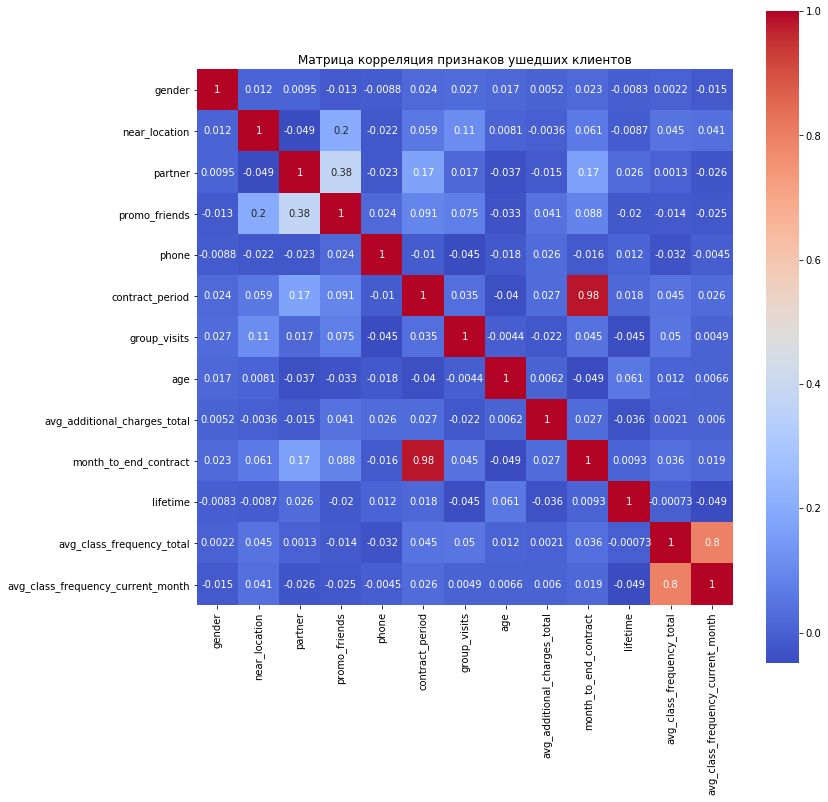

In [12]:
# Нарисуем хитмап для ушедших клиентов
plt.figure(figsize = (12,12))
sns.heatmap(corr_churn, square = True, annot = True, cmap= 'coolwarm')
plt.title('Матрица корреляция признаков ушедших клиентов')
plt.show()

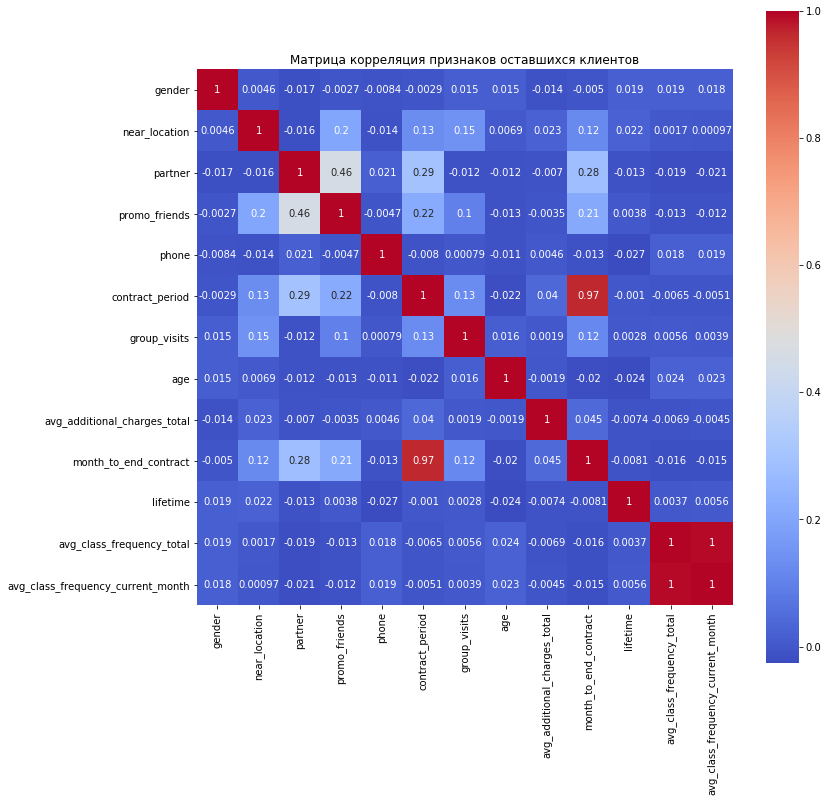

In [13]:
# Нарисуем хитмап для оставшихся клиентов
plt.figure(figsize = (12,12))
sns.heatmap(corr_no_churn, square = True, annot = True, cmap= 'coolwarm')
plt.title('Матрица корреляция признаков оставшихся клиентов')
plt.show()

<div class="alert alert-block alert-info">
Данные практически не коррелируют между собой, кроме очевидных - средних посещений в неделю и данных о контракте. От коррелирующих данных нужно избавиться для построения корректных моделей.
    
Для оставшихся клиентов наблюдаем большую корреляцию для количества посещений, остающиеся клиенты посещали зал регулярнее уходящих.
    </div>

In [14]:
# Избавимся от коррелирующих данных
client_data = client_data.drop(['avg_class_frequency_current_month', 'month_to_end_contract'], axis=1)

### EDA Выводы

1) Пропусков в таблице нет, данные приведены к нужному типу;

2) Данные распределены нормально;

3) Выявлены наиболее характерные признаки клиентов, оставляющих фитнес-центр:

- Меньшая длительность абонимента;

- Меньшая посещаемость групповых занятий;

- Меньший период до конца действия абонемента;

- Меньшее общее время занятий;

- Меньшая частота посещений тренировок

4) Данные очищены от сильно коррелирующих между собой признаков

### Построение модели прогнозирования оттока пользователей

1) Разбить данные на обучающую и валидационную выборку.

2) Обучить модель на train-выборке двумя способами:

- логистической регрессией

- случайным лесом

3) Оценить метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравнить по ним модели.

In [15]:
# Разделим данные на признаки и целевую переменную
X = client_data.drop('churn', axis = 1)
y = client_data['churn']

In [16]:
# Разделим модель на обучающую и валидационные выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=0)

In [17]:
# Стандартизируем данные
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [18]:
# Зададим список моделей
models = [LogisticRegression(), RandomForestClassifier(n_estimators = 100, random_state=0)]

In [19]:
# Напишем функцию, принимающую на вход модель и данные, а выводящую метрики
def metrics(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('accuracy:{:.3f} precision:{:.3f} recall:{:.3f}'.format(accuracy_score(y_test, y_pred),
                                                                 precision_score (y_test, y_pred),
                                                                 recall_score (y_test, y_pred)))

In [20]:
# Выведем метрики наших моделей
for i in models:
    print(i)
    metrics(i, X_train_st, y_train, X_test_st, y_test)
    print('--------------------------------------------')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
accuracy:0.907 precision:0.825 recall:0.825
--------------------------------------------
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
accuracy:0.894 precision:0.807 recall:0.7

<div class="alert alert-block alert-info">
Логистическая регрессия и случайный лес дают результаты очень близкие друг к другу, но все-таки метрики регрессии на доли процентов выше чем у леса, думаю, что это может быть связано со склонностью случайного леса к переобучению.
    
Доля верных ответов высокая - 90.7%, но не стоит забывать, что наши данные поделены не поровну, оставшихся клиентов значительно больше, чем ушедших.

В 82.5% случаях наша модель верно показывает, что клиент покинет спортзал и обнаруживает также 82.5% клиентов, реально прекративших занятия в фитнесс центре.
    
Модели не идеальны, но результат дают неплохой.
    
Посмотрим какие признаки модели считают наиболее важными для себя
 </div>

In [21]:
# Зададим модели
logistic_model = LogisticRegression()
tree_model = RandomForestClassifier(n_estimators = 100)

# Обучим модели
logistic_model.fit(X_train_st, y_train)
tree_model.fit(X_train_st, y_train)

# Сделаем датасеты с признаками и их важностью
w_logistic = pd.DataFrame({'feature': X_train.columns, 'importance':logistic_model.coef_.ravel()})
w_tree_model = pd.DataFrame({'feature': X_train.columns, 'importance':tree_model.feature_importances_})

# Для логистической регрессии приведем признаки к модулю
w_logistic['importance'] = w_logistic['importance'].abs()

In [22]:
w_logistic.sort_values(by='importance', ascending = False)

,feature,importance
9,lifetime,3.605495
5,contract_period,1.360233
7,age,1.149322
10,avg_class_frequency_total,0.698331
8,avg_additional_charges_total,0.546469
6,group_visits,0.359024
3,promo_friends,0.163335
4,phone,0.111683
1,near_location,0.073253
2,partner,0.042383


In [23]:
w_tree_model.sort_values(by='importance', ascending = False)

,feature,importance
9,lifetime,0.325186
10,avg_class_frequency_total,0.173716
7,age,0.157603
8,avg_additional_charges_total,0.134211
5,contract_period,0.115272
6,group_visits,0.021169
0,gender,0.017604
2,partner,0.017315
3,promo_friends,0.014739
1,near_location,0.013460


<div class="alert alert-block alert-info">
Модели регрессии и случайного леса по-разному видят важности признаков, но и та и другая модель ставят на первое место количество месяцев, которое клиент занимается в зале. К тому же ставят со значительным отрывом, в модели регрессии важность данного признака превосходит следующий почти в три раза, а в леса практически вдвое.
    
Несмотря на то, что важности у моделей не совпадают, первые пять признаков в обеих моделях одинаков
    </div>

### Выводы по прогнозированию оттока пользователей

1) Данные разбиты на обучающую и валидационную выборки.

2) Модели прогнозирования обучены логистической регрессией и случайным лесом.

3) По метриками accuracy, precision и recall логистическая регрессия дает результат на доли процентов выше.

4) Модели регрессии и случайного леса по-разному видят важность признаков, но самый важный и признак и первая пятерка у них одинакова.

### Кластеризация пользователей

1) Стандартизировать данные.
    
2) Построить матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисовать дендрограмму. На основании полученного графика предположить, какое количество кластеров можно выделить.

3) Обучите модель кластеризации на основании алгоритма K-Means, приняв число кластеров за n=5. Посмотреть на средние значения признаков для кластеров. Можно ли сразу что-то заметить?

4) Построить распределение признаков для кластеров. Можно ли что-то заметить по ним?

5) Для каждого полученного кластера посчитайте долю оттока.

In [24]:
# Создадим датасет для клаcтеризации
cluster_data = client_data.drop('churn', axis=1)

In [25]:
# Стандартизируем данные
cluster_data_st = scaler.fit_transform(cluster_data)

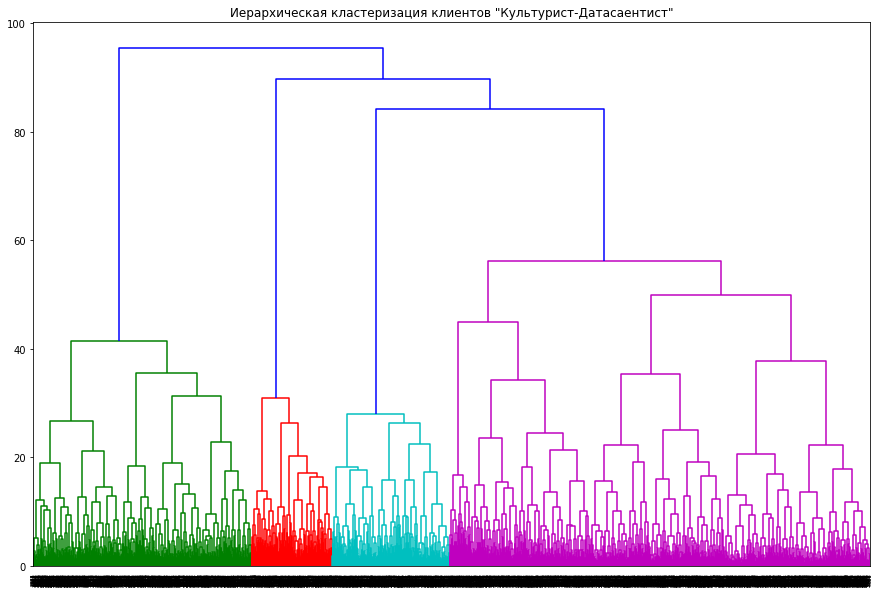

In [26]:
# Нарисуем дендограмму
linked = linkage(cluster_data_st, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация клиентов "Культурист-Датасаентист"')
plt.show()

<div class="alert alert-block alert-info">
Дендограмма предлагает нам поделить клиентов на четыре кластера   
    </div>

In [27]:
# Обучим модель алгоритмом K-means
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(cluster_data_st)

# Добавим метки кластера в датасет
client_data['cluster'] = labels

In [28]:
# Посмотрим на средние значения признаков по кластеру
client_data.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.502683,0.486867,0.561614,0.488806,0.523316
near_location,0.000000,0.996248,0.996728,1.000000,0.862694
partner,0.490161,0.942777,0.268266,0.223881,0.471503
promo_friends,0.078712,0.884615,0.049073,0.078358,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,3.000000,7.650094,5.252999,2.082090,4.777202
group_visits,0.232558,0.523452,0.533261,0.286381,0.427461
age,28.708408,29.475610,30.957470,27.584888,29.297927
avg_additional_charges_total,137.385192,149.293079,186.832439,116.455656,144.208179
lifetime,3.007156,4.057223,5.778626,1.933769,3.940415


<div class="alert alert-block alert-info">
На мой взгляд сильно выделяется кластер под номером 1. Почти по всем признаками он значительно превосходит остальные, в особенности по периоду заключенного контракта, а в модели логистической регрессии данный признак был вторым по значимости. Всего 12% клиентов данного кластера покинули фитнес-зал.
    
Нулевой и второй кластер включает себя клиентов, наиболее часто прекращающих занятия. Для нулевого кластера основная причина удаленность зала, скорее всего они переходят в фитнес-центры поближе к себе.
    
Но остальные отличия по признакам оставшихся кластеров  между собой выделить трудно. Если взять пять самых важных признаков, выделенных алгоритмами логистической регрессии и случайным лесом: временем с момента посещения, периодом контракта, возрастос, средним количеством тренировок и выручкой от других услуг фитнес центра, то мы видим, что значения в кластерах несильно отличаются между собой, а возраст, количество тренировок и выручка и вовсе практически идентичны.
    
Посмотрим детальнее на распределения признаков на графиках. Для логических и дискретных переменных построим столбчатые диаграммы, а для количественных - боксплоты.
</div>

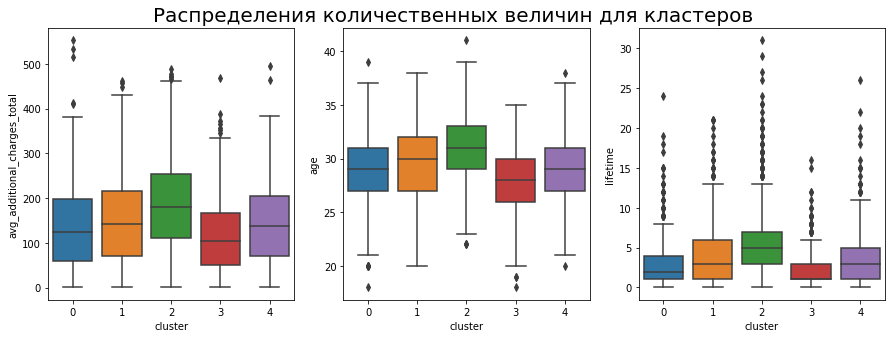

In [29]:
# Построим боксплоты
fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('Распределения количественных величин для кластеров', y = .94, fontsize=20)
sns.boxplot(x='cluster', y='avg_additional_charges_total', ax=ax[0], data=client_data)
sns.boxplot(x='cluster', y='age', ax=ax[1], data=client_data)
sns.boxplot(x='cluster', y='lifetime', ax=ax[2], data=client_data)
plt.show()

<div class="alert alert-block alert-info">
Похоже, что при распределении кластеров алгоритм несильно опирался на данные переменные, сильных отличиев между кластерами не наблюдается. Единственное, что можно выделить - это больший, по сравнению с остальными, лайфтайм у первого клсатера и меньшие у нулевого и второго, которые являются лидерами по оттоку клиентов.
    </div>

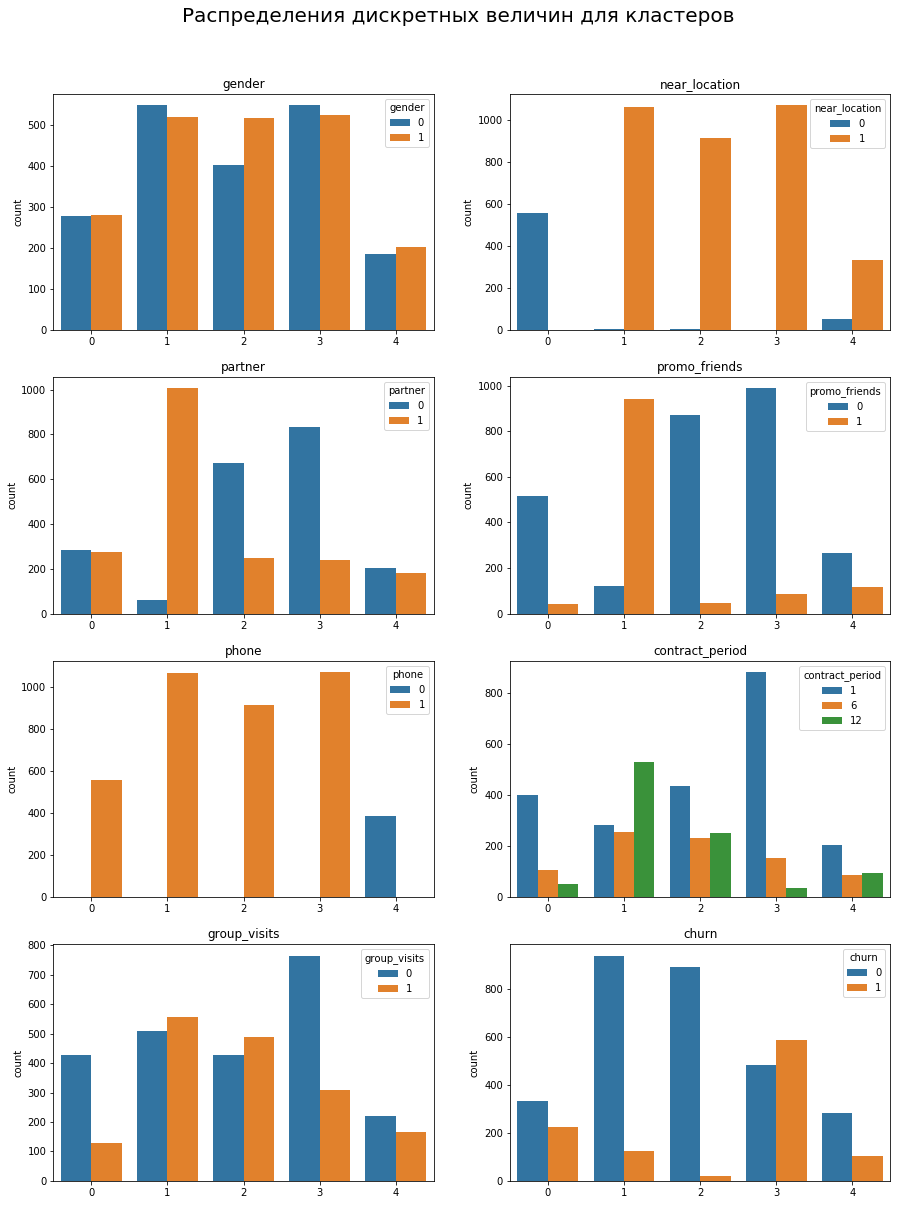

In [30]:
# Столбцы для каунтплотов
columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'churn']

# Построим боксплоты
fig, ax = plt.subplots(4,2, figsize=(15,20))
fig.suptitle('Распределения дискретных величин для кластеров', y = .94, fontsize=20)
ax = ax.ravel()
number = 0
for i in columns:
    sns.countplot(x='cluster', hue=i, ax=ax[number], data=client_data)
    ax[number].set_xlabel('')
    ax[number].set_title(i)
    number += 1
plt.show()


<div class="alert alert-block alert-info">
Следущие распределения достойны внимания:

- _Местоположение_ - Нулевой кластер состоит из клиентов, живущих далеко от спортзала, а именно такие клиенты чаще всего прекращающ занятия.

- _Партнеры клуба_ - Почти весь первый кластер состоит из партнеров клуба, а у таких клиентов доля оттока ниже.

- _Приглашение друга_ - - Почти весь первый кластер состоит клиентов, приглашенных друзьями и почти все клиенты, приглашенные друзьями попали в первый кластер, а у таких клиентов доля оттока ниже.

- _Период контракта_ - Больше всего клиентов с контрактом на год в первом кластере, а меньше всего во втором и третьем кластерах, которые как раз наиболее склонны к оттокам.

- _Групповые визиты_ - Во втором кластере у нас все клиенты не участвовали в групповых занятиях, в третьем наоборот. 

- _Отток_ - Мы уже анализировали доли оттока по кластерам, когда строили таблицу со средними значениями. Расположим наши кластеры в порядке увеличения доли оттока:

1) Первый

2) Третий

3) Четвертый

4) Второй

5) Первый
 </div>   

### Выводы кластеризации

1) Алгоритм иерархической кластеризации поделил клиентов на четыре кластера.

2) Пользователи поделены на пять кластеров с помощью алгоритам K-Means.

3) Проанализированы признаки в зависимости от кластеров.

4) Выделены надежные кластера и кластера, склонные к оттоку.

# Общий вывод

В ходе знакомства с данными проведена загрузка таблица и первичное знакомство с содержимым.

### Результаты EDA:

1) Пропусков в таблице нет, данные приведены к нужному типу.

2) Данные распределены нормально.

3) Построены и проанализированы распределения признаков в зависимости от ухода клиентов.

3) Выявлены наиболее характерные признаки клиентов, оставляющих фитнес-центр:

- Меньшая длительность абонимента;

- Меньшая посещаемость групповых занятий;

- Меньший период до конца действия абонемента;

- Меньшее общее время занятий;

- Меньшая частота посещений тренировок

4) Данные очищены от сильно коррелирующих между собой признаков

### Резльтаты построения модели прогнозирования:

1) Данные разбиты на обучающую и валидационную выборки.

2) Модели прогнозирования обучены логистической регрессией и случайным лесом.

3) По метриками accuracy, precision и recall логистическая регрессия дает результат на доли процентов выше.

4) Модели регрессии и случайного леса по-разному видят важность признаков, но самый важный и признак и первая пятерка у них одинакова.

### Результаты кластеризации:

1) Алгоритм иерархической кластеризации поделил клиентов на четыре кластера.

2) Пользователи поделены на пять кластеров с помощью алгоритам K-Means.

3) Проанализированы признаки в зависимости от кластеров.

4) Выделены надежные кластера и кластера, склонные к оттоку.

# Рекомендации по удержанию клиентов

Для рекомендаций по удержанию клиентов я бы ориентировался на гистограммы распределения признаков в зависимости от ухода клиентов.

- Расширять сектор партнеров клуба.

- Предоставлять дополнительные привилегии, скидки клиентам клуба, приводящих друзей.

- Предоставлять скидки на длительные абонементы.

- Уделять больше внимания на привлечение клиентов к групповым занятиям. Можно предложить несколько первых занятий провести бесплатно.

- Клиентам, у которых заканчивается контракт, отправлять информационные рассылки с предложением заключить новый на выгодных условиях.
